
# Research-Based Feature Engineering:
## Key Performance Indicators

Financial analysts typically assess the financial health of a company through a set of ratios derived from the company's quarterly and annual financial statements.  In this project, we use a set of ten ratios recommended by Harvard Business School as "key performance indicators" (KPI).  Our hope is that these features will enhance the base dataset and assist supervised learning algorithms in predicting company financial performance.

In [1]:
import sys
PATH_TO_MODULES = '../../..'
sys.path.insert(0, PATH_TO_MODULES)

from helpers import get_quarters

# Data Manipulation and Math/Stats Libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm

# Sci-kit Learn Functions
from sklearn.preprocessing import StandardScaler

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import plotly.express as px
import plotly.graph_objects as go

In [2]:


def make_KPIs(input_df: pd.DataFrame) -> pd.DataFrame:
    """Adds key performance indicators (KPI) to the dataset.

    Based on recommendations from Harvard Business School (HBS),
    https://online.hbs.edu/blog/post/financial-performance-measures
    
    Note: this function is not very modular; it uses column names that are
    specific to the Russell_3000 data.
    """
    dataset = input_df.copy()
    quarters = get_quarters(dataset)
    # Gross Profit Margin = (Revenue - Cost of Revenue) / Revenue
    KPI = 'KPI_GrossProfitMargin'
    for quarter in quarters:
        dataset[KPI + quarter] = (
            dataset['Revenue' + quarter] - dataset['CostOfRevenue' + quarter]
        ) / dataset['Revenue' + quarter]
    # Net Profit Margin = Net Profit / Revenue
    KPI = 'KPI_NetProfitMargin'
    for quarter in quarters:
        dataset[KPI + quarter] = (
            dataset['NetIncome' + quarter] / dataset['Revenue' + quarter]
        )
    """
    # Working Capital = Current Assets - Current Liabilities
    KPI = 'KPI_WorkingCapital'
    for quarter in quarters:
        dataset[KPI + quarter] = (
            dataset['CurrentAssets' + quarter]
            - dataset['CurrentLiabilities' + quarter]
        )
    """
    # Current Ratio = Current Assets / Current Liabilities
    KPI = 'KPI_CurrentRatio'
    for quarter in quarters:
        dataset[KPI + quarter] = (
            dataset['CurrentAssets' + quarter]
            / dataset['CurrentLiabilities' + quarter]
        )
    # Leverage = Total Assets / Total Equity
    KPI = 'KPI_Leverage'
    for quarter in quarters:
        dataset[KPI + quarter] = (
            dataset['TotalAssets' + quarter]
            / dataset['TotalEquity' + quarter]
        )
    # Debt-to-Equity Ratio = Total Debt / Total Equity
    KPI = 'KPI_DebtToEquityRatio'
    for quarter in quarters:
        dataset[KPI + quarter] = (
            dataset['TotalDebt' + quarter] / dataset['TotalEquity' + quarter]
        )
    # Total Asset Turnover = Revenue / ((Beg Total Assets + End Total Assets) / 2)
    KPI = 'KPI_TotalAssetTurnover'
    for i in range(len(quarters) - 1):
        beg, end = i, i + 1
        dataset[KPI + quarters[end]] = (
            dataset['Revenue' + quarters[end]] / ((
                dataset['TotalAssets' + quarters[beg]]
                + dataset['TotalAssets' + quarters[end]]
            ) / 2)
        )
    # Return on Equity (ROE) = Net Profit / ((Beg Equity + End Equity) / 2)
    KPI = 'KPI_ReturnOnEquity'
    for i in range(len(quarters) - 1):
        beg, end = i, i + 1
        dataset[KPI + quarters[end]] = (
            dataset['NetIncome' + quarters[end]] / ((
                dataset['TotalEquity' + quarters[beg]]
                + dataset['TotalEquity' + quarters[end]]
            ) / 2)
        )
    # Return on Assets (ROA) = Net Profit / ((Beg Total Assets + End Total Assets) / 2)
    KPI = 'KPI_ReturnOnAssets'
    for i in range(len(quarters) - 1):
        beg, end = i, i + 1
        dataset[KPI + quarters[end]] = (
            dataset['NetIncome' + quarters[end]] / ((
                dataset['TotalAssets' + quarters[beg]]
                + dataset['TotalAssets' + quarters[end]]
            ) / 2)
        )
    """
    # Cash Flow = Cash From Operations
    KPI = 'KPI_CashFlow'
    for quarter in quarters:
        dataset[KPI + quarter] = dataset['CashFromOps' + quarter]
    """
    # Return final dataframe
    return dataset

    

In [3]:
# Import merged dataset
path = PATH_TO_MODULES + '/datasets/'
input_filename, output_filename = 'X_train_filled.csv', 'X_train_filled_KPIs.csv'
df = pd.read_csv(path + input_filename)
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the dataset.')

There are 1910 rows and 109 columns in the dataset.


In [4]:
# Add KPIs
dataset = make_KPIs(df)


## Check for missing values

*credit to [Michael P. Notter](https://miykael.github.io/blog/2022/advanced_eda/) for sharing these techniques!*

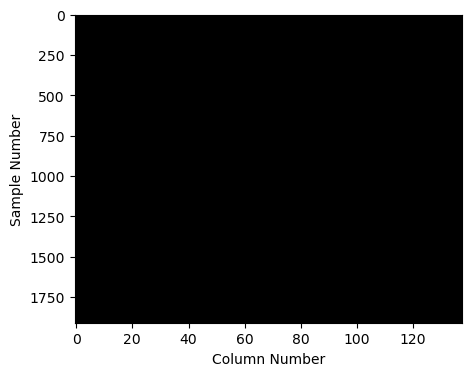

In [5]:
# Missing values show in white in the figure
plt.figure(figsize=(5, 4))
plt.imshow(dataset.isna(), aspect='auto', interpolation='nearest', cmap='gray')
plt.xlabel('Column Number')
plt.ylabel('Sample Number')
plt.show()

In [6]:
# List features missing the most data
dataset.isna().mean().sort_values(ascending=False)[:20]

Ticker                         0.0
Name                           0.0
Sector                         0.0
CapitalExpenditure_2024Q2      0.0
CapitalExpenditure_2024Q3      0.0
CapitalExpenditure_2024Q4      0.0
CapitalExpenditure_2025Q1      0.0
CashAndSTInvestments_2024Q2    0.0
CashAndSTInvestments_2024Q3    0.0
CashAndSTInvestments_2024Q4    0.0
CashAndSTInvestments_2025Q1    0.0
CashFromOps_2024Q2             0.0
CashFromOps_2024Q3             0.0
CashFromOps_2024Q4             0.0
CashFromOps_2025Q1             0.0
CostOfRevenue_2024Q2           0.0
CostOfRevenue_2024Q3           0.0
CostOfRevenue_2024Q4           0.0
CostOfRevenue_2025Q1           0.0
CurrentAssets_2024Q2           0.0
dtype: float64

In [7]:
quarters = get_quarters(dataset)
for quarter in quarters:
    print(dataset[[col for col in dataset.columns if 'KPI' in col and quarter in col]].describe())

       KPI_GrossProfitMargin_2024Q2  KPI_NetProfitMargin_2024Q2  \
count                   1910.000000                 1910.000000   
mean                       0.224910                   -0.662527   
std                        7.313802                   15.451069   
min                     -318.666667                 -575.574297   
25%                        0.230283                    0.021305   
50%                        0.398232                    0.067396   
75%                        0.606174                    0.153297   
max                        1.563410                   11.927034   

       KPI_CurrentRatio_2024Q2  KPI_Leverage_2024Q2  \
count              1910.000000          1910.000000   
mean                  3.155405             2.692591   
std                  16.599608            37.295796   
min                   0.000113         -1307.347245   
25%                   1.207431             1.855854   
50%                   1.873442             2.351177   
75%        

In [8]:
# dataset.to_csv(path + output_filename, index=False)